In [1]:
from keras import Input
from keras import Model
from keras.preprocessing.text import Tokenizer,one_hot,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
import codecs
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
import io
import re

Using TensorFlow backend.


# # Keras - Plot History
 * Plot History : plot loss and accuracy from the history
 * Full Report : print a full report and plot a confusion matrix


In [2]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy score: "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=3))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)


# Preprocessing

In [3]:

def remove_sortcut(lis,sentence):
    pattern = "[A-Z][A-Z]+"
    match = re.search(pattern, sentence)
    if match:
        s=re.sub(pattern,'',sentence)
        lis.append(s)
    else:
        lis.append(sentence)
seed = 7
np.random.seed(seed)

sentence = []
intents = []
lengths = []
f = io.open('myData.txt',encoding='utf-8')

lines = f.readlines()
for line in lines:
    l = line.split('||')
    k = l[:1]
    j = l[1:]

    for i in j:
        ii = i.strip()
        intents.append(ii)

    for i in k:
        remove_sortcut(sentence,i)
        
f.close()
# convert to lowercase
sentences=[item.lower() for item in sentence]  
# find length max of sequence
for sen in sentences:
    lengths.append(len(text_to_word_sequence(sen)))
MAX_SEQUENCE_LENGTH = max(lengths)

#prnt
print('num of sentences ',len(sentences))
print('num of intents ',len(intents))
print('max length of sentnce',MAX_SEQUENCE_LENGTH)
######
# lis=[]
# e='quantityService'
# for i in intents:
#     if e in i:
#         lis.append(e)
# print(len(lis))

num of sentences  8124
num of intents  8124
max length of sentnce 81


In [4]:
labels = []
label = ['greeting','inqueryService', 'dateService', 'beQuestion', 'placeService', 'getService', 'quantityService']
dictionary = dict(zip(label, range(len(label))))
print(dictionary)
for it in intents:
    if it in dictionary.keys():
        labels.append(dictionary.get(it))
print(dictionary.keys())

{'getService': 5, 'quantityService': 6, 'placeService': 4, 'beQuestion': 3, 'inqueryService': 1, 'greeting': 0, 'dateService': 2}
dict_keys(['getService', 'quantityService', 'placeService', 'beQuestion', 'inqueryService', 'greeting', 'dateService'])


In [5]:
t = Tokenizer()
t.fit_on_texts(sentences)
# find no of words in dataset
MAX_NB_WORDS = len(t.word_index) + 1
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4654 unique tokens.


In [6]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
intent = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', intent.shape)
EMBEDDING_DIM =100
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
intent = intent[indices]

VALIDATION_SPLIT = 0.33
nb_validation_samples = int(VALIDATION_SPLIT* data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = intent[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = intent[-nb_validation_samples:]
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))


Shape of data tensor: (8124, 81)
Shape of label tensor: (8124, 7)
5444
5444
2680
2680


In [7]:
embeddings_index = dict()
import codecs
with codecs.open('glove.6B.100d.txt','r',encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' , len(embeddings_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False
                                                        
                            )

Loaded %s word vectors. 400000


# CNN

In [14]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Conv1D,Bidirectional,MaxPooling1D,Flatten
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras import metrics
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

neurons_hidden = 60
dropout_rate1 = 0.3
dropout_rate2 =0.5
nb_filters = 200
kerana_sz =3
nb_epoch =12
b_size = 20


model = Sequential()
model.add(embedding_layer)

model.add(Dropout(dropout_rate1))
model.add(Conv1D(nb_filters, kerana_sz, activation='relu'))

model.add(GlobalMaxPooling1D())
model.add(Dense(neurons_hidden))
model.add(Dropout(dropout_rate2))
model.add(Activation('relu'))
model.add(Dense(7, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
# summarize the model
print(model.summary())
# fit the model

history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=b_size,validation_data=(x_val, y_val),shuffle=True)#validation_data=(x_val,y_val))#,validation_split=VALIDATION_SPLIT
# Final evaluation of the model
loss, accuracy = model.evaluate(x_val, y_val,batch_size=b_size)
print('Accuracy: %f' % (accuracy*100))
print('\n score',loss)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 100)           465500    
_________________________________________________________________
dropout_7 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 79, 200)           60200     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 60)                12060     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
activation_3 (Activation)    (None, 60)                0         
__________

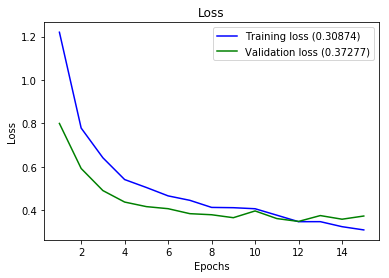

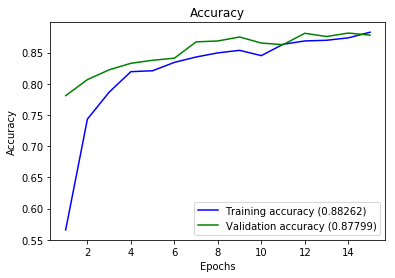

Accuracy score: 0.8779850746268657

Classification Report
             precision    recall  f1-score   support

          0      0.850     0.739     0.791        23
          1      0.879     0.857     0.868      1072
          2      0.911     0.897     0.904       195
          3      0.931     0.984     0.957       951
          4      0.900     0.961     0.930       103
          5      0.608     0.568     0.587       243
          6      0.852     0.742     0.793        93

avg / total      0.875     0.878     0.876      2680

[[ 17   0   0   5   0   1   0]
 [  1 919   7  43   9  87   6]
 [  0  11 175   3   1   0   5]
 [  1  11   1 936   1   1   0]
 [  0   0   1   3  99   0   0]
 [  1  86   3  14   0 138   1]
 [  0  18   5   1   0   0  69]]


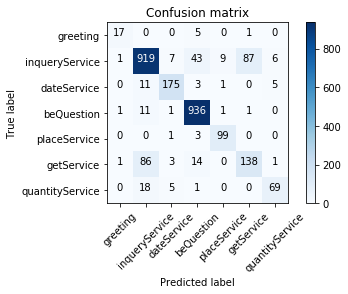

In [15]:
plot_history(history)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
classes= ['greeting','inqueryService','dateService','beQuestion','placeService','getService','quantityService']
full_multiclass_report(model, x_val, y_val,classes=classes)

In [ ]:
# model.save("backup/intent_models/model_cnn1.h5")
# print("Model saved to backup folder.")

# BLSTM

In [25]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Conv1D,Bidirectional,MaxPooling1D
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras import metrics
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
#####################
neurons_hidden = 100 # 32 
dropout_rate = 0.6
nb_epoch = 12
b_size = 20
optimizer = "rmsprop"

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_rate))
                          
model.add(Bidirectional(LSTM(neurons_hidden, return_sequences=True),
                            input_shape=(EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)))
model.add(Bidirectional(LSTM(neurons_hidden)))
model.add(Dropout(dropout_rate))
model.add(Dense(7, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
   
# summarize the model
print(model.summary())
# fit the model

history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=b_size,validation_data=(x_val, y_val),shuffle=True)#validation_data=(x_val,y_val))#,validation_split=VALIDATION_SPLIT
# Final evaluation of the model
loss, accuracy = model.evaluate(x_val, y_val,batch_size=b_size)
print('Accuracy: %f' % (accuracy*100))
print('\n score',loss)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 100)           465500    
_________________________________________________________________
dropout_17 (Dropout)         (None, 81, 100)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 81, 200)           160800    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 1407      
Total params: 868,507
Trainable params: 403,007
Non-trainable params: 465,500
________________________________________________________________

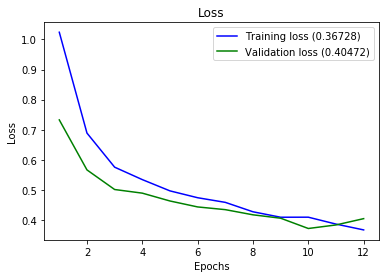

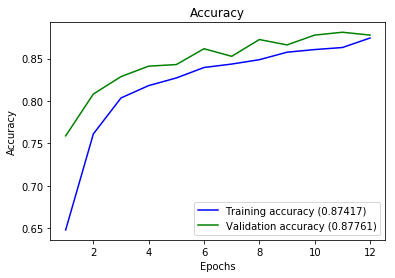

Accuracy score: 0.8776119402985074

Classification Report
             precision    recall  f1-score   support

          0      0.633     0.826     0.717        23
          1      0.872     0.877     0.874      1072
          2      0.816     0.862     0.838       195
          3      0.982     0.954     0.967       951
          4      0.885     0.971     0.926       103
          5      0.620     0.650     0.635       243
          6      0.811     0.645     0.719        93

avg / total      0.880     0.878     0.878      2680

[[ 19   1   0   0   0   3   0]
 [  5 940  11  10  10  90   6]
 [  1  15 168   3   1   1   6]
 [  3  20  16 907   1   3   1]
 [  1   0   1   1 100   0   0]
 [  1  77   4   1   1 158   1]
 [  0  25   6   2   0   0  60]]


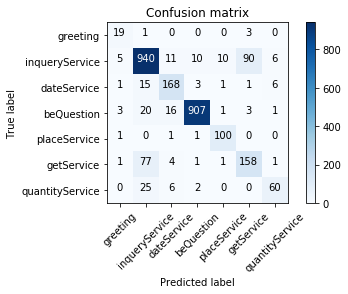

In [26]:
plot_history(history)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
classes= ['greeting','inqueryService','dateService','beQuestion','placeService','getService','quantityService']
full_multiclass_report(model, x_val, y_val,classes=classes)

In [27]:
model.save("backup/intent_models/model_blstm2.h5")
print("Model saved to backup folder.")

Model saved to backup folder.


# cnn-lstm


In [62]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Conv1D,Bidirectional,MaxPooling1D,LSTM
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras import metrics

#####################
neurons_hidden = 80
dropout_rate1 = 0.3
dropout_rate2 = 0.7
nb_epoch = 12
b_size = 20
no_filters = 200
kernal_sz = 2 #,2,4  (2,80) (3,79)
optimizer='adam'#rmsprop

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_rate1))
model.add(Conv1D(filters=no_filters,
                     kernel_size=kernal_sz,
                     padding='valid',
                     activation='relu'))

# model.add(Dropout(dropout_rate1))
model.add(MaxPooling1D(pool_size=80))
model.add(LSTM(neurons_hidden))#,recurrent_dropout=0.3,dropout=0.3))
model.add(Dropout(dropout_rate2))
model.add(Dense(80))
model.add(Activation('relu'))

model.add(Dense(7, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
   
# summarize the model
print(model.summary())
# fit the model

history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=b_size,validation_data=(x_val, y_val),shuffle=True)#validation_data=(x_val,y_val))#,validation_split=VALIDATION_SPLIT
# Final evaluation of the model
loss, accuracy = model.evaluate(x_val, y_val,batch_size=b_size)
print('Accuracy : %f' % (accuracy*100))
print('\n score',loss)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 100)           465500    
_________________________________________________________________
dropout_50 (Dropout)         (None, 81, 100)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 80, 200)           40200     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 1, 200)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 80)                89920     
_________________________________________________________________
dropout_51 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 80)                6480      
__________

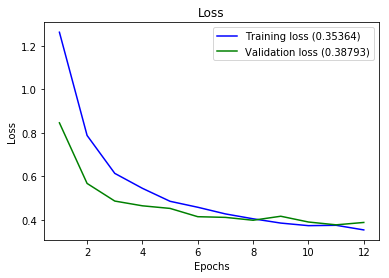

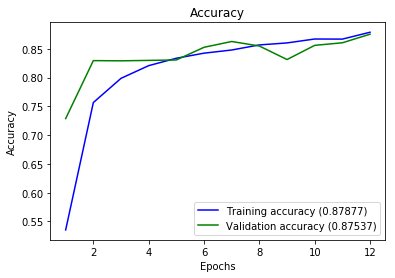

Accuracy score: 0.8753731343283582

Classification Report
             precision    recall  f1-score   support

          0      0.704     0.826     0.760        23
          1      0.881     0.867     0.874      1072
          2      0.784     0.933     0.852       195
          3      0.972     0.944     0.958       951
          4      0.877     0.971     0.922       103
          5      0.619     0.642     0.630       243
          6      0.816     0.667     0.734        93

avg / total      0.878     0.875     0.876      2680

[[ 19   0   0   0   0   4   0]
 [  3 929  16  17  11  91   5]
 [  0   6 182   2   1   0   4]
 [  2  24  20 898   2   1   4]
 [  1   0   1   1 100   0   0]
 [  2  75   3   6   0 156   1]
 [  0  21  10   0   0   0  62]]


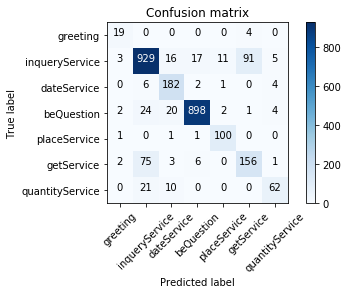

In [61]:
plot_history(history)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
classes= ['greeting','inqueryService','dateService','beQuestion','placeService','getService','quantityService']
full_multiclass_report(model, x_val, y_val,classes=classes)

In [33]:
model.save("backup/intent_models/model_c-lstm1.h5")
print("Model saved to backup folder.")

Model saved to backup folder.


# testing

In [ ]:
from keras.models import load_model
model = load_model('backup/intent_models/model_cnn1.h5')
print ("\nEnter sentence to be classified:")
test_text = input()
test_text = tokenizer.texts_to_sequences(test_text)

test_text = pad_sequences(test_text, maxlen=81)
prediction = model.predict_classes(test_text)
classes = np.argmax(prediction)
print(list(dictionary.keys())[list(dictionary.values()).index(classes)])

